### This notebook is for A Wilde's Project 2 of DATA 71200

# A description of the problem:
Given US Census data, the Current Population Survey, from 2009 with variables about income and work for people 65 and older, I would like to:

--> This is this notebook: **For the supervised project:** develop a model that can predict who is working and who is not

This notebook is cleaning and preparing the data for the supervised model project.
The data was exported from IPUMS CPS.
### Updated Cleaning from Project 1 Submission:
- Onehot encode before seperating Train and Test
- Scale after seperating Train and Test in different pipeline
- Gather meaningful feature names in cleaning process to use in visualization later
- Added imputer to handle missing values for continuous features

## In this notebook:
### Project 1:
#### 1) Loading the Data
##### Defining the Label 
#### 2) Cleaning the Data
#### 3) Applying Log
#### 4) Cleaning - one-hot encoding 
#### 5) Seperate out test set
#### 6) Standard Scaling of Test and Train
#### 7) Seperate out labels
### Project 2:
### 8) Logistic Regression
### 9) Decision Trees

In [1]:
import pandas as pd
import numpy as np

## Project 1
### 1) Load in the data

In [2]:
seniors_df = pd.read_csv("senior_data_2009_hr_t2.csv")

#### Getting a Label: 
- Calculate a combo field from EMPSTAT and WKSTAT 
- Transform to numeric

In [3]:
def combine_EMP_WKSTAT(empstat, wkstat):
    if empstat == "At work":
        if wkstat.find("Full-time") > -1:
            empwkstat = "Full-time"
        elif wkstat.find("Part-time") > -1:
            empwkstat = "Part-time"
        else:
            empwkstat = wkstat
    elif empstat.find("Unemployed") > -1:
            empwkstat = "Unemployed"
    else:
        empwkstat = empstat    
    return empwkstat

In [4]:
seniors_df['EMPWKSTAT'] = seniors_df.apply(lambda row: combine_EMP_WKSTAT(row['EMPSTAT'],row['WKSTAT']),axis=1)
seniors_df['EMPWKSTAT'].value_counts()

NILF, retired                     15865
Full-time                          1756
Part-time                          1715
NILF, unable to work               1084
NILF, other                         547
Unemployed                          225
Has job, not at work last week      210
Name: EMPWKSTAT, dtype: int64

In [5]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
seniors_empwkstat = seniors_df['EMPWKSTAT']
seniors_empwkstat_encoded = encoder.fit_transform(seniors_empwkstat)
seniors_df['EMPWKSTAT_Num']= pd.DataFrame(seniors_empwkstat_encoded)

In [6]:
seniors_df['EMPWKSTAT_Num'].value_counts()

3    15865
0     1756
5     1715
4     1084
2      547
6      225
1      210
Name: EMPWKSTAT_Num, dtype: int64

### 2) Data Cleaning
- Calculating New Values
- Dropping correlated values
- Handling Nulls

The following for calculating new values was adapted from the book *Hands-on Machine Learning* Chapter 2

#### Combining Attributes 
- for citizen percent of life **note this uses a hardcoded year value for this data (From 2009)**
- total passive income

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin

In [8]:
# Class to combine attributes for Percent of Life one was Citizen and Total Passive Income
# Instantiation 
#   Input: 2 boolean values to add the two columns
# Fit method does nothing
# Transform method 
#   Input: All Attributes in a DataFrame
#   Output: All Attributes in a DataFrame 
class DF_CombinedAttributesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self,add_citizen_percent_of_life = True, add_total_passive_inc = True):
        self.add_citizen_percent_of_life = add_citizen_percent_of_life
        self.add_total_passive_inc = add_total_passive_inc
    def fit(self, X, y = None):
        return self # nothing to do on fit
    def transform(self, X_df, y = None):
        #X is a data frame
        X_df_copy = X_df.copy(deep=True)
        if self.add_citizen_percent_of_life:
            X_df_copy['percent_of_life']=X_df_copy.apply(lambda row: (2009-int(row['YRIMMIG'][0:4]))/int(row['AGE']) if not pd.isna(row['YRIMMIG']) else 1,axis = 1)
        if self.add_total_passive_inc:
            X_df_copy['passive_inc'] = X_df_copy.apply(lambda row: row['INCTOT']-row['all_wages']-row['all_business_farm'],axis = 1)
        return X_df_copy

In [11]:
#test it
#adder = DF_CombinedAttributesTransformer()
#strat_seniors_train_combined_attribs = adder.transform(strat_seniors_train)
#strat_seniors_train_combined_attribs['percent_of_life'].value_counts()

#### Transformer for Dropping The Unnecssary Columns
This is also adapted from *Hands-on Machine Learning* Chapter 2

In [9]:
# Class to drop attributes
# Instantiation 
#   Input: a list of the columns to drop
# Fit method does nothing
# Transform method 
#   Input: All Attributes in a DataFrame
#   Output: All Attributes in a DataFrame - the dropped columns
class DF_DropColumnsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop):
        self.columns_to_drop = columns_to_drop
    def fit(self, X, y=None):
        return self #nothing to fit
    def transform(self, X_df, y=None):
        #X is a Data Frame
        return X_df.drop(columns = self.columns_to_drop)

In [18]:
#test dropping class transformer
#dropper = DF_DropColumnsTransformer(['INCTOT', 'all_wages', 'INCLONGJ'])
#strat_seniors_train_combined_attribs_thinned = dropper.transform(strat_seniors_train_combined_attribs)
#strat_seniors_train_combined_attribs_thinned.columns

#### Class to address null values in the following remaining columns

In [10]:
null_counts = {}
for column in seniors_df.columns:
    count = seniors_df[column].isnull().sum()
    if count != 0:
        null_counts[column]= count


In [11]:
# Object of the keys and appropriate null values
null_values = {'PUBHOUS':'NIU','RENTSUB':'NIU','HISPAN':'NIU','SRCRETI1':'None','SRCRETI2':'None',
               'GOTVDISA':'NIU','GOTVOTHE':'NIU','GOTVPENS':'NIU','GOTVSURV':'NIU','all_survivor':0}

In [12]:
# Class to replace null values in given columns
# Instantiation 
#   Input: an object of the column names and their associated null value replacements
# Fit method does nothing
# Transform method 
#   Input: All Attributes in a DataFrame
#   Output: All Attributes in a DataFrame with the null values replaced
class DF_ReplaceNullValuesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, null_value_replacements):
        self.null_value_replacements = null_value_replacements
    def fit(self, X, y=None):
        return self #nothing to fit
    def transform(self, X_df, y=None):
        #X is a Data Frame
        X_df_copy = X_df.copy(deep=True)
        for key, value in self.null_value_replacements.items():
            X_df_copy[key]=X_df_copy[key].apply(lambda x: value if pd.isna(x) else x)
        return X_df_copy

In [16]:
#test replace null values Transformer
#null_replacer = DF_ReplaceNullValuesTransformer(null_values)
#strat_seniors_train_combined_attribs_thinned_replaced = null_replacer.transform(strat_seniors_train_combined_attribs_thinned)
#null_counts = {}
#for column in strat_seniors_train_combined_attribs_thinned_replaced.columns:
#    count = strat_seniors_train_combined_attribs_thinned_replaced[column].isnull().sum()
#    if count != 0:
#        null_counts[column]= count
#null_counts

#### Pipeline of these Cleaning Steps
- DF_CombinedAttributesTransformer
- DF_DropColumnsTransformer
- DF_ReplaceNullValuesTransformer

Define the real values for: 
- Columns to drop
- null value replacements

In [13]:
from sklearn.pipeline import Pipeline

In [14]:
# list of columns to drop:
columns_to_drop = ['FTOTVAL','INCTOT','INCOTHER','INCLONGJ','WKSWORK1','WHYPTLY','TAXINC','HOURWAGE','UNION',
                   'reported_inc_diff','all_wages','CLASSWKR','UHRSWORKT','SRCEARN','ratio_tax_income','multi_jobs',
                   'YRIMMIG','OCC','IND','CPSIDP','EMPSTAT','WKSTAT','all_business_farm']

# Object of the keys and appropriate null value replacements
null_value_replacements = {'PUBHOUS':'NIU','RENTSUB':'NIU','HISPAN':'NIU','SRCRETI1':'None','SRCRETI2':'None',
               'GOTVDISA':'NIU','GOTVOTHE':'NIU','GOTVPENS':'NIU','GOTVSURV':'NIU','all_survivor':0}

#### Run the Pipeline

In [15]:
df_cleaning_pipeline = Pipeline([
    ('combiner',DF_CombinedAttributesTransformer()),
    ('dropper',DF_DropColumnsTransformer(columns_to_drop)),
    ('null_replacer',DF_ReplaceNullValuesTransformer(null_value_replacements))
])
seniors_df_cleaned = df_cleaning_pipeline.fit_transform(seniors_df)

### 3) Applying logorithmic transform

because this is useful

Other transforms below, but not used

In [16]:
log_column_list=['INCDIVID','INCRETIR']

In [17]:
# Class to apply logorithmic scaling to a given list of columns
# Instantiation 
#   Input: a list of columns to scale logorithmically
# Fit method does nothing
# Transform method 
#   Input: All Attributes in a DataFrame
#   Output: All Attributes in a DataFrame with the null values replaced
class DF_GetLogValuesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_log):
        self.columns_to_log = columns_to_log
    def fit(self, X, y=None):
        return self #nothing to fit
    def transform(self, X_df, y=None):
        #X is a Data Frame
        X_df_copy = X_df.copy(deep=True)
        for column in self.columns_to_log:
            X_df_copy[column]=X_df_copy[column].apply(lambda x: np.log(x+1))
        return X_df_copy

In [18]:
get_logs = DF_GetLogValuesTransformer(log_column_list)
seniors_df_cleaned_log = get_logs.fit_transform(seniors_df_cleaned)
seniors_df_cleaned_log.shape

(21402, 30)

### 4) Cleaning of Data:

#### Attribute One-hot (best done before splitting test) 
Adapted from *Hands-on Machine Learning* Chapter 2

In [19]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [20]:
# define columns for numeric vs categorical pipelines
numeric_columns = ['HOUSRET','AGE','INCSS','INCWELFR','INCRETIR','INCSSI','INCDIVID','INCALIM',
                   'all_disability','all_survivor','percent_of_life','passive_inc']
categor_columns = ['OWNERSHP','PUBHOUS','RENTSUB','SEX','RACE','MARST','CITIZEN','HISPAN','EDUC','SRCRETI1',
                  'GOTVDISA','GOTVOTHE','GOTVPENS','GOTVSURV','SRCRETI2']
passthrough_numeric = ['EMPWKSTAT_Num']
passthrough_categor = ['EMPWKSTAT']

In [21]:
# Helper transformer to seperate out the given columns of a DataFrame
# Instantiation 
#   Input: a list of the columns to select
# Fit method does nothing
# Transform method 
#   Input: All Attributes in a DataFrame
#   Output: NP Array with just the selected columns
class DF_NP_Column_Selector(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_select):
        self.columns_to_select = columns_to_select
    def fit(self, X, y=None):
        return self #nothing to fit
    def transform(self, X_df, y=None):
        #X is a Data Frame
        return X_df[self.columns_to_select].to_numpy()
    def get_feature_names(self):
        return self.columns_to_select

In [22]:
categor_pipeline= Pipeline([
    ('selector', DF_NP_Column_Selector(categor_columns)),
    ('1hot_encoder', OneHotEncoder())
])

#### One hot encode the categorical values

In [23]:
categor_cols = categor_pipeline.fit_transform(seniors_df_cleaned_log)
categor_cols.shape

(21402, 87)

In [24]:
categor_names = categor_pipeline['1hot_encoder'].get_feature_names()
len(categor_names)

87

#### Re-join to orginal data

In [25]:
seniors_to_join= seniors_df_cleaned.drop(columns=categor_columns)
curr_columns = seniors_to_join.columns
np_seniors_to_join=seniors_to_join.to_numpy()

In [26]:
categor_cols=categor_cols.toarray()

In [27]:
seniors_np_categor_processed = np.column_stack((np_seniors_to_join,categor_cols))

In [28]:
seniors_df_categor_processed = pd.DataFrame(seniors_np_categor_processed, columns = [*curr_columns,*categor_names])

#### Seperate out test and train before standard scaling

### 5) Seperate out a test set
(stratified by employment status)

Adapted from Hands On Machine Learning book

In [29]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.25, random_state=17)
for train_index, test_index in split.split(seniors_df_categor_processed, seniors_df_categor_processed['EMPWKSTAT_Num']):
    strat_seniors_train = seniors_df_categor_processed.loc[train_index]
    strat_seniors_test = seniors_df_categor_processed.loc[test_index]

In [30]:
strat_seniors_train['EMPWKSTAT'].value_counts() /len(strat_seniors_train)

NILF, retired                     0.741262
Full-time                         0.082051
Part-time                         0.080120
NILF, unable to work              0.050651
NILF, other                       0.025544
Unemployed                        0.010529
Has job, not at work last week    0.009844
Name: EMPWKSTAT, dtype: float64

In [31]:
strat_seniors_test['EMPWKSTAT'].value_counts() /len(strat_seniors_test)

NILF, retired                     0.741357
Full-time                         0.082041
Part-time                         0.080172
NILF, unable to work              0.050645
NILF, other                       0.025603
Unemployed                        0.010465
Has job, not at work last week    0.009718
Name: EMPWKSTAT, dtype: float64

In [32]:
strat_seniors_train.shape

(16051, 102)

In [33]:
strat_seniors_test.shape

(5351, 102)

### 6) Standard Scaling

In [34]:
from sklearn.impute import SimpleImputer
numeric_pipeline = Pipeline([
    ('selector', DF_NP_Column_Selector(numeric_columns)),
    ('std_scaler', StandardScaler()),
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='constant', fill_value=0))
])

In [35]:
train_numeric_cols = numeric_pipeline.fit_transform(strat_seniors_train)
train_numeric_cols.shape

(16051, 12)

In [36]:
test_numeric_cols = numeric_pipeline.fit_transform(strat_seniors_test)
test_numeric_cols.shape

(5351, 12)

##### Rejoin to the original data
- for Train
- for Test

In [37]:
strat_seniors_train_to_join= strat_seniors_train.drop(columns=numeric_columns)
curr_columns = strat_seniors_train_to_join.columns
np_strat_seniors_train_to_join=strat_seniors_train_to_join.to_numpy()

In [38]:
strat_seniors_train_prepared = np.column_stack((np_strat_seniors_train_to_join,train_numeric_cols))

In [39]:
seniors_df_train = pd.DataFrame(strat_seniors_train_prepared, columns = [*curr_columns,*numeric_columns])

In [40]:
strat_seniors_test_to_join= strat_seniors_test.drop(columns=numeric_columns)
curr_columns = strat_seniors_test_to_join.columns
np_strat_seniors_test_to_join=strat_seniors_test_to_join.to_numpy()

In [41]:
strat_seniors_test_prepared = np.column_stack((np_strat_seniors_test_to_join,test_numeric_cols))

In [42]:
seniors_df_test = pd.DataFrame(strat_seniors_test_prepared, columns = [*curr_columns,*numeric_columns], )

##### Drop the label Num value used in earlier visualizations and 

In [43]:
seniors_df_train=seniors_df_train.drop(columns='EMPWKSTAT_Num')
seniors_df_test=seniors_df_test.drop(columns='EMPWKSTAT_Num')

### 7) Seperate the labels 

In [44]:
# Seperate out the labels
# Instantiation 
#   Input: the label column
# Fit method does nothing
# Transform method 
#   Input: All Attributes in a DataFrame
#   Output: Dataframe without the labels, NP array of the labels
class DF_NP_Cat_Label_Seperator(BaseEstimator, TransformerMixin):
    def __init__(self, label_column):
        self.label_column = label_column
    def fit(self, X, y=None):
        return self #nothing to fit
    def transform(self, X_df, y=None):
        #X is a Data Frame
        labels_np = X_df[self.label_column].to_numpy()
        X_df_no_labels = X_df.drop(columns=self.label_column)
        return X_df_no_labels, labels_np

In [45]:
label_seperator = DF_NP_Cat_Label_Seperator('EMPWKSTAT')
seniors_df_train_nol, train_labels = label_seperator.transform(seniors_df_train)
seniors_df_test_nol, test_labels = label_seperator.transform(seniors_df_test) 

In [46]:
seniors_np_train_nol = seniors_df_train_nol.to_numpy()

In [47]:
seniors_np_test_nol = seniors_df_test_nol.to_numpy()

## Project 2:

## 8) Try a simple model - Logistic Regression
- run with default settings
- run CV to determine best setting

#### Default

In [48]:
from sklearn.linear_model import LogisticRegression

In [49]:
logreg= LogisticRegression()

In [50]:
logreg.fit(seniors_np_train_nol, train_labels)
print("Training set score: {:.2f}".format(logreg.score(seniors_np_train_nol, train_labels)))
print("Test set score: {:.2f}".format(logreg.score(seniors_np_test_nol, test_labels)))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Training set score: 0.76
Test set score: 0.75


In [51]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, logreg.predict(seniors_np_test_nol)))

                                precision    recall  f1-score   support

                     Full-time       0.49      0.19      0.28       439
Has job, not at work last week       0.00      0.00      0.00        52
                   NILF, other       0.50      0.01      0.01       137
                 NILF, retired       0.76      0.99      0.86      3967
          NILF, unable to work       0.42      0.04      0.07       271
                     Part-time       0.00      0.00      0.00       429
                    Unemployed       0.00      0.00      0.00        56

                      accuracy                           0.75      5351
                     macro avg       0.31      0.18      0.18      5351
                  weighted avg       0.64      0.75      0.66      5351



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### GridSearch + CV to find the best hyper parameters

In [56]:
from sklearn.model_selection import StratifiedShuffleSplit
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=17)

In [57]:
from sklearn.model_selection import GridSearchCV
C_range = [.001,.01, .1, 1, 10, 100]
param_grid = dict(C=C_range)

# polynomial kernel
grid_logreg = GridSearchCV(LogisticRegression(solver='liblinear',multi_class='auto'), param_grid=param_grid, cv=cv)
grid_logreg.fit(seniors_np_train_nol, train_labels)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=17, test_size=0.2,
            train_size=None),
             error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='liblinear',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [58]:
print("The best parameters are %s with a score of %0.2f"
      % (grid_logreg.best_params_, grid_logreg.best_score_))

The best parameters are {'C': 100} with a score of 0.75


In [59]:
print(classification_report(test_labels, grid_logreg.best_estimator_.predict(seniors_np_test_nol)))

                                precision    recall  f1-score   support

                     Full-time       0.51      0.20      0.29       439
Has job, not at work last week       0.00      0.00      0.00        52
                   NILF, other       0.33      0.01      0.01       137
                 NILF, retired       0.76      0.99      0.86      3967
          NILF, unable to work       0.42      0.04      0.07       271
                     Part-time       0.00      0.00      0.00       429
                    Unemployed       0.00      0.00      0.00        56

                      accuracy                           0.75      5351
                     macro avg       0.29      0.18      0.18      5351
                  weighted avg       0.64      0.75      0.67      5351



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [62]:
grid_logreg.best_estimator_.coef_

array([[ 3.64793235e-05, -5.29826649e-01,  5.57831362e-02,
        -3.41164766e-01,  5.57831362e-02, -2.53287427e-01,
        -6.17703989e-01, -5.61920853e-01,  5.47184107e-01,
        -8.00471533e-01, -9.05114294e-01,  8.99060150e-02,
         3.32103202e-01,  1.03700877e-01, -2.69837098e-01,
        -4.52038760e-01, -1.74937516e-02,  9.42217533e-01,
        -1.25158851e-01, -5.33260969e-01, -7.12899608e-04,
        -5.21096401e-01,  6.15375791e-01, -4.82273539e-01,
        -1.94720469e-01, -2.12012943e-01,  4.56337542e-02,
        -6.95577684e-02, -3.50791460e-01,  8.00191272e-02,
        -9.88949772e-02, -4.21616955e-01, -1.71519144e-01,
         5.25797643e-02, -3.79297312e-01,  9.62087272e-02,
        -4.13180315e-01,  8.40584175e-03, -8.75281352e-01,
         2.97764783e-01, -1.49173053e-01, -1.66415063e-01,
         6.94905640e-02, -3.80173354e-01,  3.97940627e-01,
         1.79444738e-01,  5.38377188e-01,  1.36162474e+00,
        -3.72735792e-01, -5.10509770e-01, -3.44548042e-0

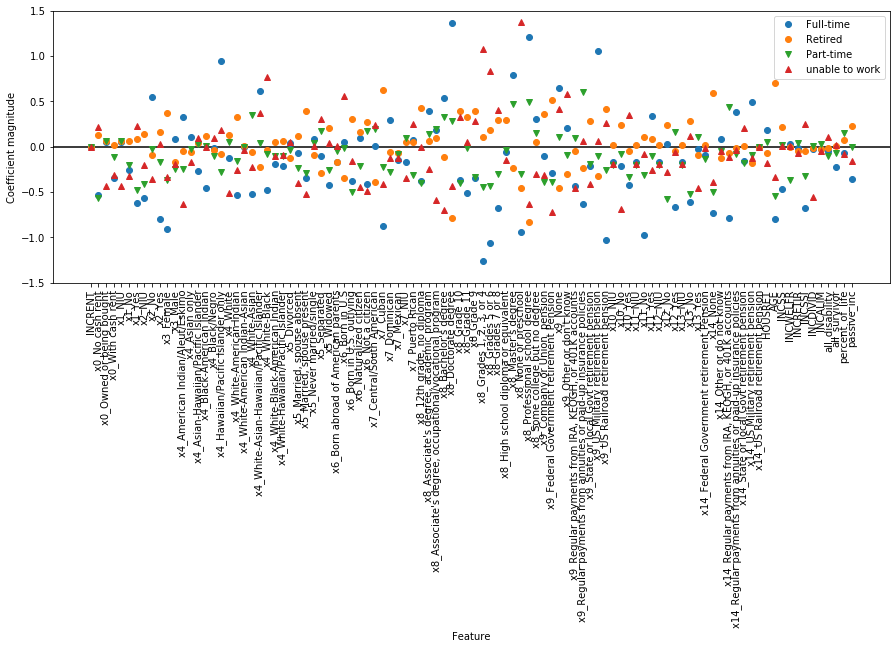

In [76]:
%matplotlib inline 
import matplotlib.pyplot as plt 

plt.subplots(1, 1, figsize=(15, 5))
plt.plot(grid_logreg.best_estimator_.coef_[0], 'o', label="Full-time")
plt.plot(grid_logreg.best_estimator_.coef_[3], 'o', label="Retired")
plt.plot(grid_logreg.best_estimator_.coef_[5], 'v', label="Part-time")
plt.plot(grid_logreg.best_estimator_.coef_[4], '^', label="unable to work")
plt.xticks(range(seniors_np_train_nol.shape[1]), seniors_df_train_nol.columns, rotation=90)
xlims = plt.xlim()
plt.hlines(0, xlims[0], xlims[1])
plt.xlim(xlims)
plt.ylim(-1.5, 1.5)
plt.xlabel("Feature")
plt.ylabel("Coefficient magnitude")
plt.legend()

## 9) Try some complex models:
- Naive Bayes, 
- Decision Trees incl. Random Forrest, and Gradient Boosting Decision Trees

#### Naive Bayes Gaussian model

In [67]:
from sklearn.naive_bayes import GaussianNB

In [68]:
gNB_bad = GaussianNB()
gNB_bad.fit(seniors_np_train_nol, train_labels)

GaussianNB(priors=None, var_smoothing=1e-09)

In [69]:
print("Training set score: {:.2f}".format(gNB_bad.score(seniors_np_train_nol, train_labels)))
print("Test set score: {:.2f}".format(gNB_bad.score(seniors_np_test_nol, test_labels)))

Training set score: 0.07
Test set score: 0.06


In [70]:
gNB_bad.get_params()

{'priors': None, 'var_smoothing': 1e-09}

In [63]:
from sklearn.model_selection import GridSearchCV
var_smoothing_range = [.0001,.001, .01, 1, 10, 100]
param_grid = dict(var_smoothing=var_smoothing_range)

# polynomial kernel
grid_gNB = GridSearchCV(GaussianNB(), param_grid=param_grid, cv=cv)
grid_gNB.fit(seniors_np_train_nol, train_labels)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=17, test_size=0.2,
            train_size=None),
             error_score='raise-deprecating',
             estimator=GaussianNB(priors=None, var_smoothing=1e-09), iid='warn',
             n_jobs=None,
             param_grid={'var_smoothing': [0.0001, 0.001, 0.01, 1, 10, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [64]:
print("The best parameters are %s with a score of %0.2f"
      % (grid_gNB.best_params_, grid_gNB.best_score_))

The best parameters are {'var_smoothing': 10} with a score of 0.74


In [65]:
print(classification_report(test_labels, grid_gNB.best_estimator_.predict(seniors_np_test_nol)))

                                precision    recall  f1-score   support

                     Full-time       0.00      0.00      0.00       439
Has job, not at work last week       0.00      0.00      0.00        52
                   NILF, other       0.00      0.00      0.00       137
                 NILF, retired       0.74      1.00      0.85      3967
          NILF, unable to work       0.00      0.00      0.00       271
                     Part-time       0.00      0.00      0.00       429
                    Unemployed       0.00      0.00      0.00        56

                      accuracy                           0.74      5351
                     macro avg       0.11      0.14      0.12      5351
                  weighted avg       0.55      0.74      0.63      5351



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### Helper function to plot feature importance

In [71]:


def plot_feature_importances(model, data, feature_names):
    n_features = data.shape[1]
    plt.barh(np.arange(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

### Decision Tree 

In [67]:
from sklearn.tree import DecisionTreeClassifier

In [68]:
tree_bad = DecisionTreeClassifier()

In [69]:
tree_bad.fit(seniors_np_train_nol, train_labels)
print("Accuracy on training set: {:.3f}".format(tree_bad.score(seniors_np_train_nol, train_labels)))
print("Accuracy on test set: {:.3f}".format(tree_bad.score(seniors_np_test_nol, test_labels)))

Accuracy on training set: 1.000
Accuracy on test set: 0.613


In [71]:
max_depth_range = [1,2,5,20,50,100]
min_samples_leaf_range = [1,2,5,20,50,100]
param_grid = dict(max_depth=max_depth_range,min_samples_leaf=min_samples_leaf_range)

## DecisionTree
grid_tree = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid, cv=cv)
grid_tree.fit(seniors_np_train_nol, train_labels)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=17, test_size=0.2,
            train_size=None),
             error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'max

In [72]:
print("The best parameters are %s with a score of %0.2f"
      % (grid_tree.best_params_, grid_tree.best_score_))

The best parameters are {'max_depth': 20, 'min_samples_leaf': 50} with a score of 0.75


In [73]:
print(classification_report(test_labels, grid_tree.best_estimator_.predict(seniors_np_test_nol)))

                                precision    recall  f1-score   support

                     Full-time       0.45      0.29      0.35       439
Has job, not at work last week       0.00      0.00      0.00        52
                   NILF, other       0.00      0.00      0.00       137
                 NILF, retired       0.77      0.98      0.86      3967
          NILF, unable to work       0.00      0.00      0.00       271
                     Part-time       0.14      0.01      0.01       429
                    Unemployed       0.00      0.00      0.00        56

                      accuracy                           0.75      5351
                     macro avg       0.19      0.18      0.17      5351
                  weighted avg       0.62      0.75      0.67      5351



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


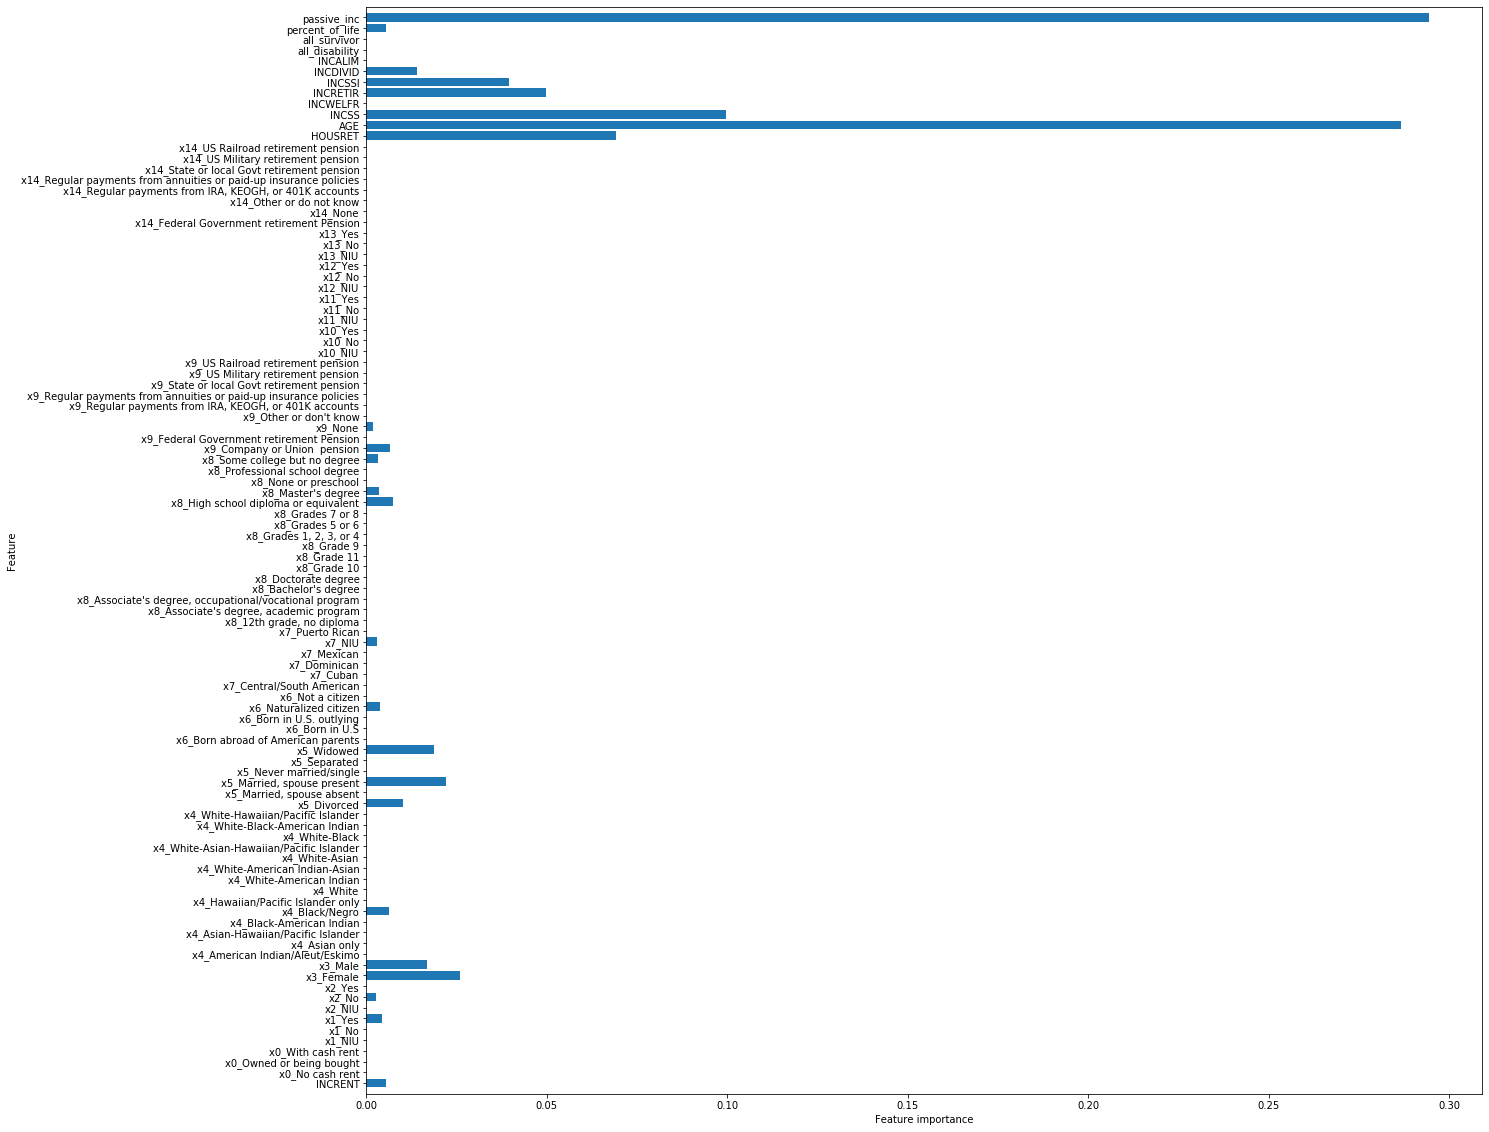

In [79]:
fig, axes = plt.subplots(1, 1, figsize=(20, 20))
plot_feature_importances(grid_tree.best_estimator_, seniors_np_train_nol, seniors_df_train_nol.columns)

### Random Forest

In [52]:
from sklearn.ensemble import RandomForestClassifier

In [53]:
forest = RandomForestClassifier()
forest.fit(seniors_np_train_nol, train_labels)
print("Accuracy on training set: {:.3f}".format(forest.score(seniors_np_train_nol, train_labels)))
print("Accuracy on test set: {:.3f}".format(forest.score(seniors_np_test_nol, test_labels)))

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Accuracy on training set: 0.981
Accuracy on test set: 0.734


In [54]:
print(classification_report(test_labels, forest.predict(seniors_np_test_nol)))

                                precision    recall  f1-score   support

                     Full-time       0.38      0.29      0.33       439
Has job, not at work last week       0.00      0.00      0.00        52
                   NILF, other       0.04      0.01      0.01       137
                 NILF, retired       0.78      0.95      0.85      3967
          NILF, unable to work       0.33      0.08      0.13       271
                     Part-time       0.12      0.02      0.03       429
                    Unemployed       0.00      0.00      0.00        56

                      accuracy                           0.73      5351
                     macro avg       0.24      0.19      0.19      5351
                  weighted avg       0.63      0.73      0.67      5351



In [83]:
n_estimators_range = [2,5,10,20,50]
max_features_range = [2,5,10,20,50]
min_samples_leaf_range = [1,2,5]
param_grid = dict(n_estimators=n_estimators_range,max_features=max_features_range,
                  min_samples_leaf=min_samples_leaf_range)

# polynomial kernel
grid_forest = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=cv)
grid_forest.fit(seniors_np_train_nol, train_labels)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=17, test_size=0.2,
            train_size=None),
             error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              rand

In [84]:
print("The best parameters are %s with a score of %0.2f"
      % (grid_forest.best_params_, grid_forest.best_score_))

The best parameters are {'max_features': 20, 'min_samples_leaf': 5, 'n_estimators': 50} with a score of 0.76


In [85]:
print(classification_report(test_labels, grid_forest.best_estimator_.predict(seniors_np_test_nol)))

                                precision    recall  f1-score   support

                     Full-time       0.50      0.28      0.36       439
Has job, not at work last week       0.00      0.00      0.00        52
                   NILF, other       0.00      0.00      0.00       137
                 NILF, retired       0.77      0.99      0.86      3967
          NILF, unable to work       0.50      0.02      0.04       271
                     Part-time       0.00      0.00      0.00       429
                    Unemployed       0.00      0.00      0.00        56

                      accuracy                           0.76      5351
                     macro avg       0.25      0.18      0.18      5351
                  weighted avg       0.64      0.76      0.67      5351



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


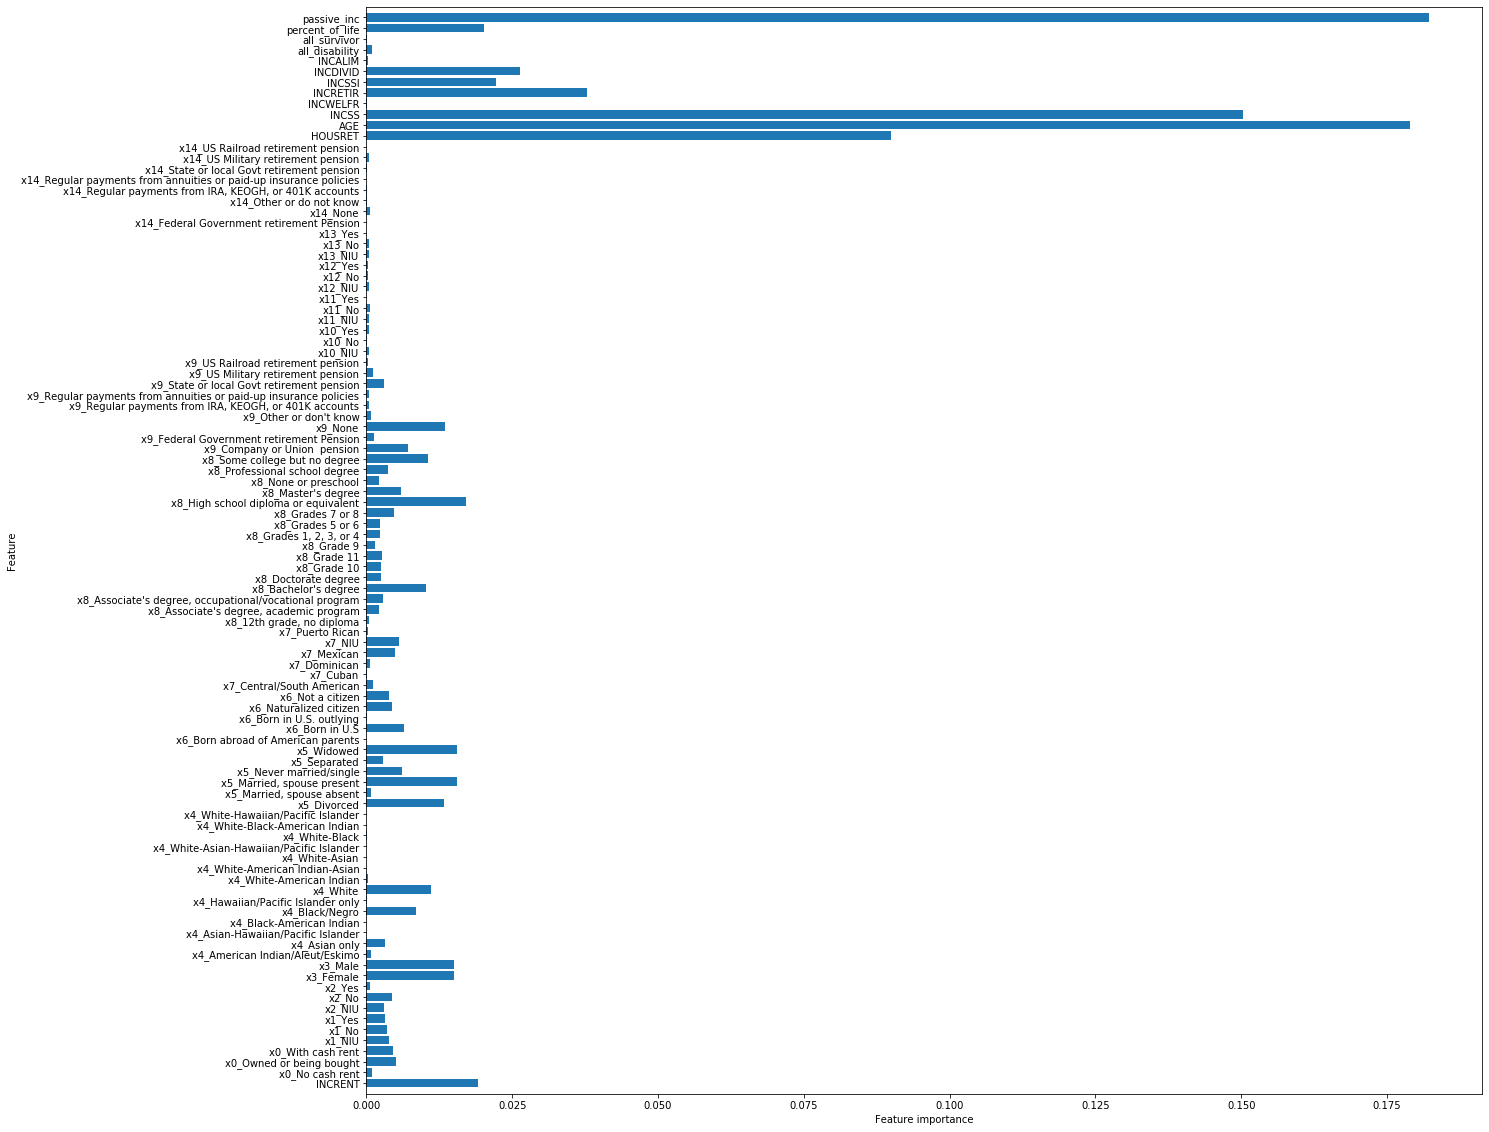

In [86]:
fig, axes = plt.subplots(1, 1, figsize=(20, 20))
plot_feature_importances(grid_forest.best_estimator_, seniors_np_train_nol, seniors_df_train_nol.columns)

### Gradient Boosting Decision Trees

In [87]:
from sklearn.ensemble import GradientBoostingClassifier

gbrt = GradientBoostingClassifier(random_state=17)
gbrt.fit(seniors_np_train_nol, train_labels)

print("Accuracy on training set: {:.3f}".format(gbrt.score(seniors_np_train_nol, train_labels)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(seniors_np_test_nol, test_labels)))

Accuracy on training set: 0.785
Accuracy on test set: 0.722


In [88]:
n_estimators_range = [2,5,10,20,30]
max_depth_range = [2,5,10]
param_grid = dict(n_estimators=n_estimators_range,max_depth=max_depth_range)

# polynomial kernel
grid_boostedforest = GridSearchCV(GradientBoostingClassifier(), param_grid=param_grid, cv=cv)
grid_boostedforest.fit(seniors_np_train_nol, train_labels)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=17, test_size=0.2,
            train_size=None),
             error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_lea...
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                         

In [89]:
print("The best parameters are %s with a score of %0.2f"
      % (grid_boostedforest.best_params_, grid_boostedforest.best_score_))

The best parameters are {'max_depth': 2, 'n_estimators': 30} with a score of 0.75


In [90]:
print(classification_report(test_labels, grid_boostedforest.best_estimator_.predict(seniors_np_test_nol)))

                                precision    recall  f1-score   support

                     Full-time       0.51      0.17      0.26       439
Has job, not at work last week       0.00      0.00      0.00        52
                   NILF, other       0.00      0.00      0.00       137
                 NILF, retired       0.77      0.98      0.86      3967
          NILF, unable to work       0.49      0.07      0.12       271
                     Part-time       0.08      0.02      0.03       429
                    Unemployed       0.00      0.00      0.00        56

                      accuracy                           0.75      5351
                     macro avg       0.26      0.18      0.18      5351
                  weighted avg       0.64      0.75      0.67      5351



/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


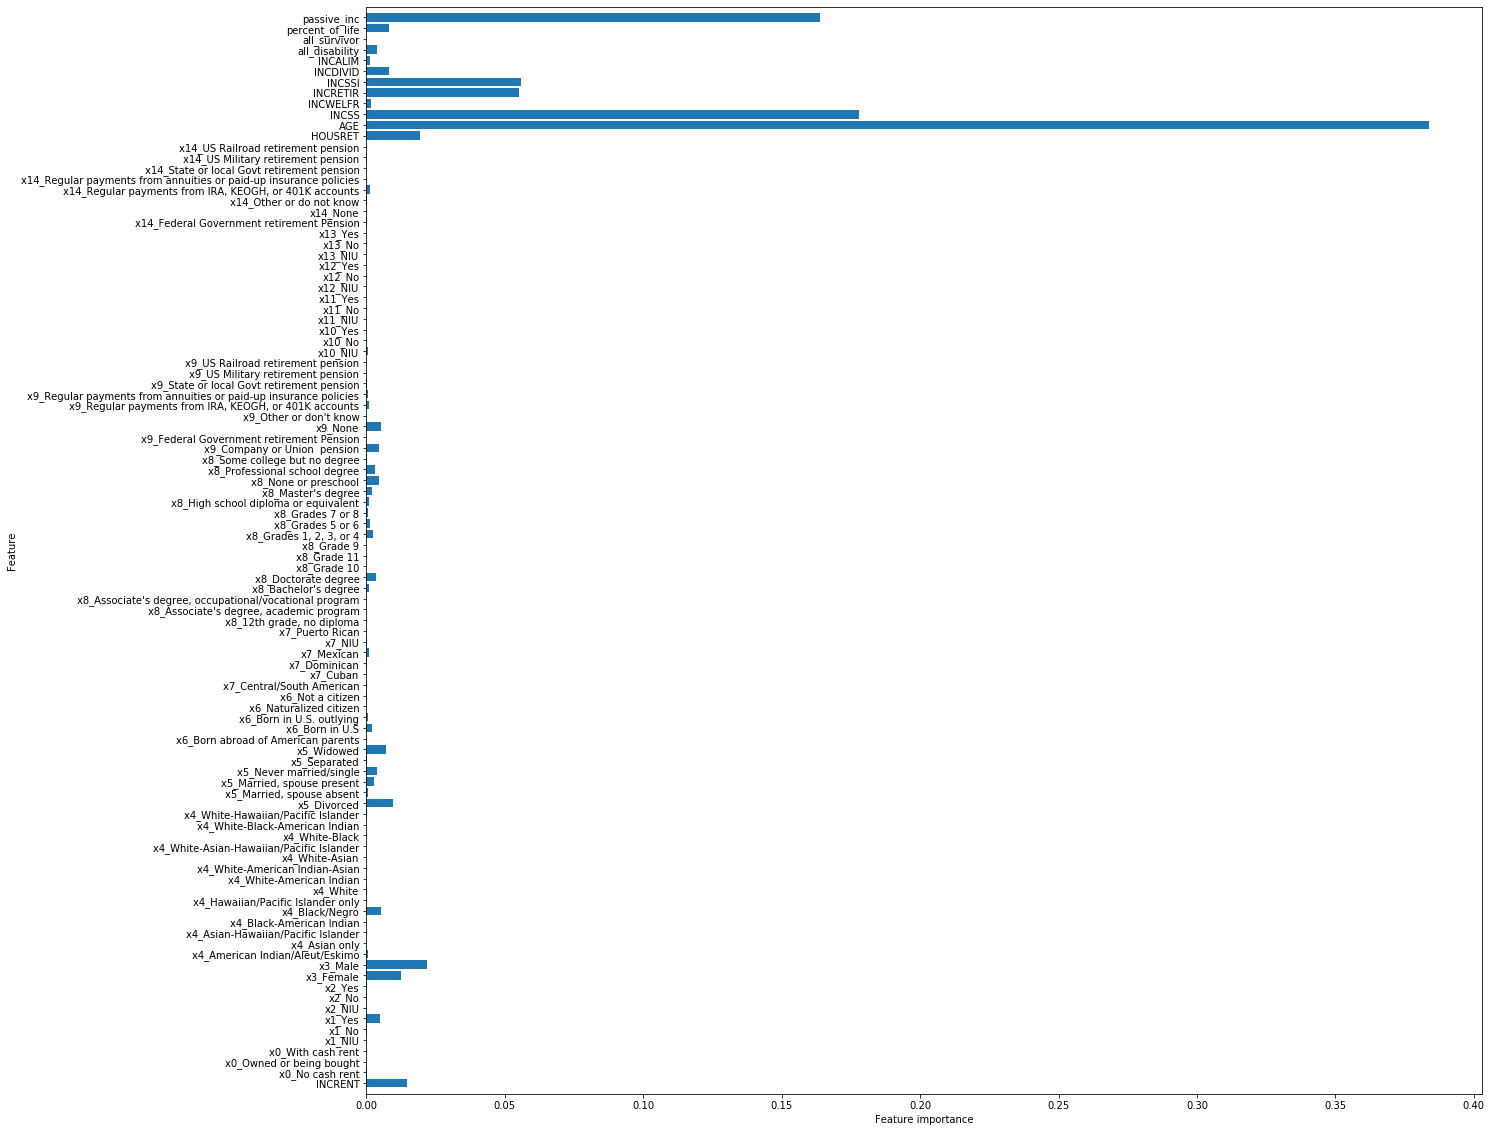

In [91]:
fig, axes = plt.subplots(1, 1, figsize=(20, 20))
plot_feature_importances(grid_boostedforest.best_estimator_, seniors_np_train_nol, seniors_df_train_nol.columns)

## Notes from Project 2:

Most of the models have very similar results, with the regular decision tree providing the best f1-scores for both retired (.86) and working full-time (.35). Interestingly the Gaussian Naive Bayes model did not predict working people at all, only retirees. This Gaussian Naive Bayes model also was, with it's default parameters, remarkably bad at scoring. All of the rest of the models only saw marginal gains between the default parameters and the tuned hyper-parameters. 

The most important features are age, the value of the house that the person lives in (a proxy for class) and the incomes from non-work that a person has. Interestingly in the more complex decision trees, the relative importance of passive income decreases, and the importance of gender (male vs female) switches for gradient boosted.  In the best model (regular decision tree) race is only relevant if a person is black and citizenship is only very marginally relevant for people who are naturalized citizens. Divorced, Widowed or Married with spouse present all seem to be relevant categories.